In [1]:
%%html
<style>
.container {
    width:100% !important;
}
</style>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1,'/Users/shuojia/CSV/lhapdf/build/bin')
import lhapdf
import numpy as np
import json
import math
from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
print('iminuit version: ',iminuit.__version__)
import PyPDF2
import os
%matplotlib inline


ModuleNotFoundError: No module named 'lhapdf'

In [14]:
set_cteq6 = lhapdf.getPDFSet("JAM20-SIDIS_PDF_proton_nlo")
p_cteq6 = set_cteq6.mkPDFs()
JAM20 = lhapdf.mkPDF("JAM20-SIDIS_FF_pion_nlo", 0)

LHAPDF 6.4.0 loading all 196 PDFs in set JAM20-SIDIS_PDF_proton_nlo
JAM20-SIDIS_PDF_proton_nlo, version 2; 196 PDF members
LHAPDF 6.4.0 loading /home/hdbhatt/Downloads/LHAPDF-6.4.0/build/share/LHAPDF/JAM20-SIDIS_FF_pion_nlo/JAM20-SIDIS_FF_pion_nlo_0000.dat
JAM20-SIDIS_FF_pion_nlo PDF set, member #0, version 2; LHAPDF ID = 2052000


In [25]:
data_all = pd.read_csv('x_q2_z_kin34567_alldata_mult_index.txt',delim_whitespace=True)
#data_all = pd.read_csv('oneline.txt',delim_whitespace=True)
data_all.head(100)

,#x,Q2,z,h2p,h2perr,d2p,d2perr,h2n,h2nerr,d2n,d2nerr,index,Fp1,Fm1,Up1,Um1,h2p1,h2n1,d2p1,d2n1
0,0.445,4.476,0.325,0.7847,0.0164,0.6851,0.0143,0.4198,0.015,0.485,0.0136,1,0.2,0.1,0.25,0.12,1,1,1,1


In [26]:
def h_dmult(n,x,Q,z,Fp,Fm,Up,Um):
    ux = p_cteq6[0].xfxQ(2, x, Q)
    dx = p_cteq6[0].xfxQ(1, x, Q)
    ubarx = p_cteq6[0].xfxQ(-2, x, Q)
    dbarx = p_cteq6[0].xfxQ(-1, x, Q)
    u = np.asarray(ux)
    d = np.asarray(dx)
    ubar = np.asarray(ubarx)
    dbar = np.asarray(dbarx)
    h2p = (4*u*Fp    + dbar*Fm + d*Up    + 4*ubar*Um) /(4*u + 4*ubar + d + dbar)
    h2n = (4*ubar*Fp + d*Fm    + dbar* Up + 4*u*Um)  / (4*u + 4*ubar + d + dbar)
    d2p = (4*Fp*(u+d)+ Fm *(ubar+dbar) + Up *(u+d) + 4*Um*(ubar+dbar)) / (5*(u+ubar+d+dbar))
    d2n = (4*Fp*(ubar+dbar)+Fm*(u+d)+Up*(ubar+dbar)+4*Um*(u+d))/(5*(u+ubar+d+dbar))
    if n==1:
        return h2p
    if n==2:
        return h2n
    if n==3:
        return d2p
    if n==4:
        return d2n

In [27]:
def least_squares_1stQ21(Fp,Fm,Up,Um):  
    least_square1=0
    #do 1 row at a time 
    for i,row in data_all.iterrows():
        x=row['#x']
        z=row['z']
        Q=np.sqrt(row['Q2'])
        meas_h2p=row['h2p']
        meas_h2perr=row['h2perr']
        meas_d2p=row['d2p']
        meas_d2perr=row['d2perr']
        meas_h2n=row['h2n']
        meas_h2nerr=row['h2nerr']
        meas_d2n=row['d2n']
        meas_d2nerr=row['d2nerr']
        least_square1= (meas_h2p-h_dmult(1,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_h2perr**2)  + (meas_h2n-h_dmult(2,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_h2nerr**2) + (meas_d2p-h_dmult(3,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_d2perr**2)+ (meas_d2n-h_dmult(4,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_d2nerr**2)
    return least_square1


In [28]:
inits=(0.2, 0.1, 0.25, 0.12)

Fp = 0.8367567623299524 +/- 0.027313482213000225
Fm = 0.8239892256876538 +/- 0.13957373964996977
Up = 0.11523168781109802 +/- 0.14944770035493937
Um = 0.39106300931470206 +/- 0.02509953515405565
Function minimum:  8.442419168601456e-18
Number of data points:  1
Number of fit parameters:  4
Total number of parameters:  4
Chi-square:  8.442419168601456e-18
Degrees of freedom:  0
Chi-square per degree of freedom:  8.442419168601456e-18


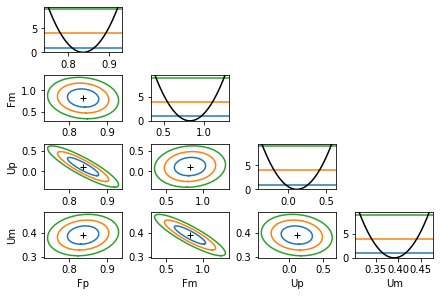

In [29]:
m_1stQ21 = Minuit(least_squares_1stQ21,Fp = inits[0],Fm = inits[1],Up=inits[2],Um=inits[3])
print("initial values: ", m_1stQ21.values)
# m_1stQ21.limits['Fp'] = (0,1)
# m_1stQ21.limits['Fm'] = (0,1)
# m_1stQ21.limits['Up'] = (0,1)
# m_1stQ21.limits['Um'] = (0,1)
m_1stQ21.migrad()
m_1stQ21.hesse()
m_1stQ21.draw_mnmatrix(cl=[1, 2, 3])
Fp = m_1stQ21.values['Fp']
Fm = m_1stQ21.values['Fm']
Up = m_1stQ21.values['Up']
Um = m_1stQ21.values['Um']
print("Fp =", Fp, "+/-", m_1stQ21.errors['Fp'])
print("Fm =", Fm, "+/-", m_1stQ21.errors['Fm'])
print("Up =", Up, "+/-", m_1stQ21.errors['Up'])
print("Um =", Um, "+/-", m_1stQ21.errors['Um'])
print("Function minimum: ", m_1stQ21.fval)
chi2_min = m_1stQ21.fval
ndof = 4*len(data_all) - m_1stQ21.nfit
#chi2_per_dof = chi2_min / ndof
chi2_per_dof = chi2_min 

print("Number of data points: ", len(data_all))
print("Number of fit parameters: ", m_1stQ21.nfit)
print("Total number of parameters: ", m_1stQ21.npar)
print("Chi-square: ", chi2_min)
print("Degrees of freedom: ", ndof)
print("Chi-square per degree of freedom: ", chi2_per_dof)

#print("h2p =",h2p)
#print("h2p_new =",h_dmult(1,x,Q,z,Fp,Fm,Up,Um))


In [ ]:
inits=(0.2, 0.1, 0.25, 0.12)
with open("output_1.txt","w") as f:
    f.write("#x\tQ\tz\tmeas_h2p\tmeas_h2perr\tmeas_d2p\tmeas_d2perr\tmeas_h2n\tmeas_h2nerr\tmeas_d2n\tmeas_d2nerr\tFp\tFm\tUp\tUm\n")

    #f=open('output.out','w')
    #print("x,z,Q,h2p,h2perr,d2p,d2perr,h2n,h2nerr,d2n,d2nerr,Fp,Fm,Up,Um",file=f)
    for i,row in data_all.iterrows():
        x=row['#x']
        z=row['z']
        Q=np.sqrt(row['Q2'])
        meas_h2p=row['h2p']
        meas_h2perr=row['h2perr']
        meas_d2p=row['d2p']
        meas_d2perr=row['d2perr']
        meas_h2n=row['h2n']
        meas_h2nerr=row['h2nerr']
        meas_d2n=row['d2n']
        meas_d2nerr=row['d2nerr']
        least_square1=0
        def least_squares_1stQ21(Fp,Fm,Up,Um):
            least_square1= (meas_h2p-h_dmult(1,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_h2perr**2)  + (meas_h2n-h_dmult(2,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_h2nerr**2) + (meas_d2p-h_dmult(3,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_d2perr**2)+ (meas_d2n-h_dmult(4,x,Q,z,Fp,Fm,Up,Um))**2 / (meas_d2nerr**2)
            return least_square1
        m_1stQ21 = Minuit(least_squares_1stQ21,Fp = inits[0],Fm = inits[1],Up=inits[2],Um=inits[3])
        print("initial values: ", m_1stQ21.values)
        # m_1stQ21.limits['Fp'] = (0,1)
        # m_1stQ21.limits['Fm'] = (0,1)
        # m_1stQ21.limits['Up'] = (0,1)
        # m_1stQ21.limits['Um'] = (0,1)
        m_1stQ21.migrad()
        m_1stQ21.hesse()
        m_1stQ21.draw_mnmatrix(cl=[1, 2, 3])
        Fp = m_1stQ21.values['Fp']
        Fm = m_1stQ21.values['Fm']
        Up = m_1stQ21.values['Up']
        Um = m_1stQ21.values['Um']
        print("Fp =", Fp, "+/-", m_1stQ21.errors['Fp'],end='')
        print("Fm =", Fm, "+/-", m_1stQ21.errors['Fm'],end='')
        print("Up =", Up, "+/-", m_1stQ21.errors['Up'],end='')
        print("Um =", Um, "+/-", m_1stQ21.errors['Um'],end='')
        print("Function minimum: ", m_1stQ21.fval)
        chi2_min = m_1stQ21.fval
        ndof = 4*len(data_all) - m_1stQ21.nfit
        #chi2_per_dof = chi2_min / ndof
        chi2_per_dof = chi2_min

        print("Number of data points: ", len(data_all),end='')
        print("Number of fit parameters: ", m_1stQ21.nfit,end='')
        print("Total number of parameters: ", m_1stQ21.npar,end='')
        print("Chi-square: ", chi2_min,end='')
        print("Degrees of freedom: ", ndof,end='')
        print("Chi-square per degree of freedom: ", chi2_per_dof,end='')
        #print("x,z,Q2,h2p,h2perr,d2p,d2perr,h2n,h2nerr,d2n,d2nerr,Fp,Fm,Up,Um",file=f)
        #print('%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f\n'%(x,z,Q,meas_h2p,meas_h2perr,meas_d2p,meas_d2perr,meas_h2n,meas_h2nerr,meas_d2n,meas_d2nerr,Fp,Fm,Up,Um),file=f)
        #print('%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f\n'%(x,z,Q,meas_h2p,meas_h2perr,meas_d2p,meas_d2perr,meas_h2n,meas_h2nerr,meas_d2n,meas_d2nerr,Fp,Fm,Up,Um))
        #f.write('%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f,%f\n'%(x,z,Q,meas_h2p,meas_h2perr,meas_d2p,meas_d2perr,meas_h2n,meas_h2nerr,meas_d2n,meas_d2nerr,Fp,Fm,Up,Um))
        f.write(f"{x:.2f}\t{Q:.3f}\t{z:.3f}\t{meas_h2p:.6f}\t{meas_h2perr:.6f}\t{meas_d2p:.6f}\t{meas_d2perr:.6f}\t{meas_h2n:.6f}\t{meas_h2nerr:.6f}\t{meas_d2n:.6f}\t{meas_d2nerr:.6f}\t{hFp:.6f}\t{Fm:.6f}\t{Up:.6f}\t{Um:.6f}\n")
f.close()

In [10]:
with open("output_1.txt","w") as f:
    f.write("#x\tQ\tz\tmeas_h2p\tmeas_h2perr\tmeas_d2p\tmeas_d2perr\tmeas_h2n\tmeas_h2nerr\tmeas_d2n\tmeas_d2nerr\tFp\tFm\tUp\tUm\n")
    for i in range(0,10):
        f.write('%d'%(i))
f.close()